## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tunning BART/ELECTRA/... ;)

to improve the translation quality.

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set.
# The checkpoints are:

# * __21__ - minimal score to submit the homework, 30% of points

# * __25__ - good score, 70% of points

# * __27__ - excellent score, 100% of points

### WordPunctTokenizer + Attention

In [ ]:
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log

!wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install transformers==3.2.0
!pip install transformers[sentencepiece]
!pip install sentencepiece

In [ ]:
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log

In [ ]:
from sklearn.model_selection import train_test_split

data = []
for line in open('data.txt'):
    data.append(line.strip().split('\t'))

train_data, val_data = train_test_split(data, test_size=0.2,
                                                          random_state=42)

In [ ]:
train_data[0]

['In Liverpool’s business district, Days Inn Liverpool is a 10-minute walk from the famous Albert Dock.',
 'Отель Days Inn Liverpool находится в деловом районе Ливерпуля, в 10 минутах ходьбы от знаменитого Альберт-Дока.']

In [ ]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()
src, trg = train_data[0]

In [ ]:
src

'In Liverpool’s business district, Days Inn Liverpool is a 10-minute walk from the famous Albert Dock.'

In [ ]:
def tokenize(sent):
    return tokenizer.tokenize(sent.rstrip().lower())


print(tokenize(src))
print(tokenize(trg))

['in', 'liverpool', '’', 's', 'business', 'district', ',', 'days', 'inn', 'liverpool', 'is', 'a', '10', '-', 'minute', 'walk', 'from', 'the', 'famous', 'albert', 'dock', '.']
['отель', 'days', 'inn', 'liverpool', 'находится', 'в', 'деловом', 'районе', 'ливерпуля', ',', 'в', '10', 'минутах', 'ходьбы', 'от', 'знаменитого', 'альберт', '-', 'дока', '.']


In [ ]:
from collections import Counter

from torchtext.vocab import vocab as Vocab


src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=2)
trg_vocab = Vocab(trg_counter, min_freq=2)

In [ ]:
len(src_vocab), len(trg_vocab)

(10122, 14112)

In [ ]:
unk_token = "<unk>"

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

In [ ]:
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token]
for vocab in [src_vocab, trg_vocab]:
    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(trg_vocab)}")

Unique tokens in source (de) vocabulary: 10126
Unique tokens in target (en) vocabulary: 14116


In [ ]:
# Tokenize sentence and add <sos> and <eos> special tokens.
tokenized = [sos_token] + tokenize(trg) + [eos_token]

# Transform tokens into indices using our vocab.
encoded = [trg_vocab[tok] for tok in tokenized]

[(tok, idx) for tok, idx in zip(tokenized, encoded)]

[('<sos>', 14113),
 ('в', 6),
 ('5', 84),
 ('км', 32),
 ('от', 14),
 ('апартаментов', 180),
 ('расположена', 82),
 ('деревня', 2289),
 ('лутра', 13916),
 ('.', 19),
 ('расстояние', 20),
 ('до', 21),
 ('города', 640),
 ('митилена', 0),
 ('составляет', 30),
 ('13', 3191),
 ('км', 32),
 ('.', 19),
 ('<eos>', 14114)]

In [ ]:
def encode(sent, vocab):
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]
print(encode(src, src_vocab)[::-1])
print(encode(trg, trg_vocab))

[10124, 21, 30, 2332, 50, 10, 3204, 173, 639, 17, 79, 7, 83, 30, 86, 10, 9946, 173, 722, 17, 10123]
[14113, 6, 84, 32, 14, 180, 82, 2289, 13916, 19, 20, 21, 640, 0, 30, 3191, 32, 19, 14114]


In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        src_encoded = encode(src, src_vocab)[::-1]
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])

    return src_padded, trg_padded


batch_size = 32
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([91, 32]), torch.Size([66, 32]))

In [ ]:
val_dataloader = DataLoader(val_data, batch_size, collate_fn=collate_batch)

In [ ]:
from torch import nn


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):


        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))


        return outputs, hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)

    def forward(self, hidden, encoder_outputs):

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim=1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):


        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim = 2)

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))

        return prediction, hidden.squeeze(0), a

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):


        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)

        input = trg[0,:]

        for t in range(1, trg_len):
            output, hidden, a = self.decoder(input, hidden, encoder_outputs)

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1

        return outputs

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
OUTPUT_DIM

14116

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10126, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(14116, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=14116, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,949,220 trainable parameters


In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

In [ ]:
from torch.nn.utils import clip_grad_norm_
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

import torch.nn.functional as F
import random



writer = SummaryWriter()
n_epochs = 10
clip = 1
global_step = 0  # for writer
for epoch in trange(n_epochs, desc="Epochs"):
    model.train()
    train_loss = 0
    for src, trg in tqdm(train_dataloader, desc="Train", leave=False):
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()
        writer.add_scalar("Training/loss", loss.item(), global_step)
        global_step += 1

    train_loss /= len(train_dataloader)
    writer.add_scalar("Evaluation/train_loss", train_loss, epoch)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(val_dataloader, desc="Val", leave=False):
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    writer.add_scalar("Evaluation/val_loss", val_loss, epoch)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Val:   0%|          | 0/313 [00:00<?, ?it/s]

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Val:   0%|          | 0/313 [00:00<?, ?it/s]

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Val:   0%|          | 0/313 [00:00<?, ?it/s]

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Val:   0%|          | 0/313 [00:00<?, ?it/s]

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Val:   0%|          | 0/313 [00:00<?, ?it/s]

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Val:   0%|          | 0/313 [00:00<?, ?it/s]

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Val:   0%|          | 0/313 [00:00<?, ?it/s]

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Val:   0%|          | 0/313 [00:00<?, ?it/s]

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Val:   0%|          | 0/313 [00:00<?, ?it/s]

Train:   0%|          | 0/1250 [00:00<?, ?it/s]

Val:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), "lstm_attention_model.pt")

In [ ]:
model.load_state_dict(torch.load("lstm_attention_model.pt"))

<All keys matched successfully>

In [ ]:
src_itos = {src_vocab[token]: token for token in src_vocab.get_itos()}
trg_itos = {trg_vocab[token]: token for token in trg_vocab.get_itos()}

In [ ]:
def translate_sentence(
    sentence,
    model,
    src_itos,
    trg_itos,
    src_vocab,
    trg_vocab,
    sos_token='<sos>',
    eos_token='<eos>',
    device='cuda:0',
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        src_ids = encode(sentence, src_vocab)[::-1]
        src_tokens = [src_itos[token_id] for token_id in src_ids]
        src_tensor = torch.LongTensor(src_ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(src_tensor)
        inputs = [trg_vocab[sos_token]]
        attentions = torch.zeros(max_output_length, 1, len(src_ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == trg_vocab[eos_token]:
                break
    trg_tokens = [trg_itos[input] for input in inputs]
    return trg_tokens, src_tokens, attentions[: len(trg_tokens) - 1]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [ ]:
sentence = val_data[0][0]
expected_translation = val_data[0][1]

sentence, expected_translation

('A shared equipped kitchen and a common living room are provided to guests.',
 'В распоряжении гостей общая кухня и общая гостиная.')

In [ ]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    src_itos,
    trg_itos,
    src_vocab,
    trg_vocab
)

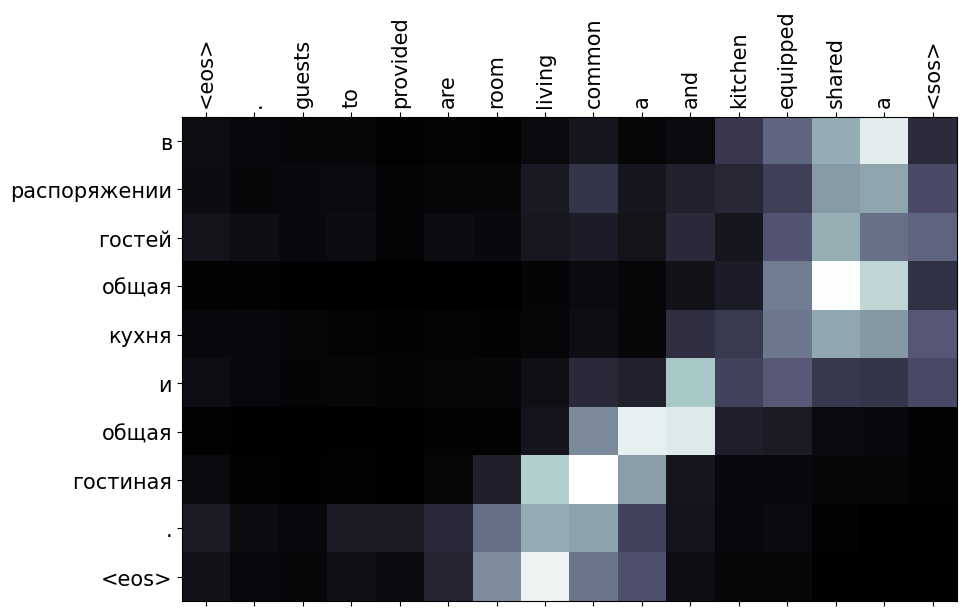

In [ ]:
import numpy as np

plot_attention(sentence_tokens, translation, attention)

In [ ]:
print(f"src: '{sentence.rstrip().lower()}'")
print(f"trg: '{expected_translation.rstrip().lower()}'")
print(f"pred: '{' '.join(translation[1:-1])}'")
print()

src: 'a shared equipped kitchen and a common living room are provided to guests.'
trg: 'в распоряжении гостей общая кухня и общая гостиная.'
pred: 'в распоряжении гостей общая кухня и общая гостиная .'



In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import torch


def translate_sentence(model, src_sentence, src_vocab, trg_vocab, sos_token, eos_token, device):
    model.eval()
    with torch.no_grad():
        src_ids = encode(src_sentence, src_vocab)[::-1]
        src_tensor = torch.LongTensor(src_ids).unsqueeze(1).to(device)
        encoder_outputs, hidden = model.encoder(src_tensor)

        trg_ids = [trg_vocab[sos_token]]
        outputs = []
        for i in range(100):
            trg_tensor = torch.LongTensor([trg_ids[-1]]).to(device)
            with torch.no_grad():
                output, hidden, _ = model.decoder(trg_tensor, hidden, encoder_outputs)
                pred_token = output.argmax(1).item()
                trg_ids.append(pred_token)
                if pred_token == trg_vocab[eos_token]:
                    break
        outputs = [trg_itos[idx] for idx in trg_ids[1:-1]]
    return outputs

references = []
candidates = []

for src, trg in val_data:
    trg_tokens = trg.lower().split()
    translation_output = translate_sentence(model, src, src_vocab, trg_vocab, '<sos>', '<eos>', device)
    references.append([trg_tokens])
    candidates.append(translation_output)

bleu_score = corpus_bleu(references, candidates)
print(f"BLEU score on validation set: {bleu_score}")


BLEU score on validation set: 0.1404505694580977


# bpe without attention

In [ ]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:21<00:00, 378.37it/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [ ]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

Draw source and translation length distributions to estimate the scope of the task.

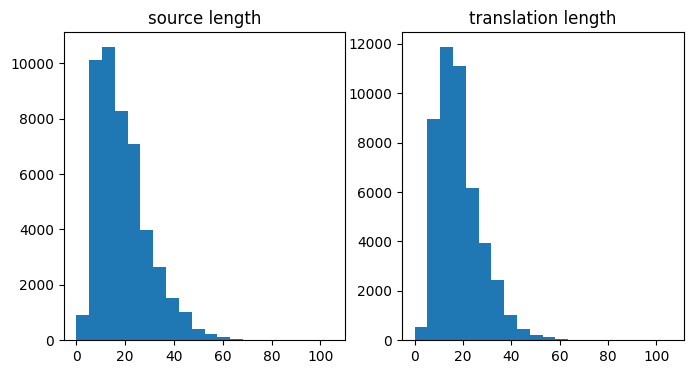

In [ ]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):

        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]


        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):

        [dec_start,] = prev_state # dec_start = prev_state[0]

        prev_tokens_embs = self.emb_out(prev_tokens)

        new_gru_activations = self.dec0(prev_tokens_embs, dec_start)
        new_dec_state = [new_gru_activations]

        output_logits = self.logits(new_gru_activations)

        return new_dec_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state

        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:

model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
art art art art art art art art art art art art art art art art art art art art art art art art art
art art art art art art art art art art art art art art art art art art art art art art art art art
art art art art art art art art art art art art art art art art art art art art art art art art art


In [ ]:

def compute_loss(model, inp, out, **flags):

    mask = model.out_voc.compute_mask(out)
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    logits_seq = model(inp, out)
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    loss_values = -logp_out * mask
    return loss_values.sum() / mask.sum()

In [ ]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

dummy_loss.backward()

Loss: tensor(7.5452, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):

    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            )

In [ ]:
compute_bleu(model, dev_inp, dev_out)

6.426230990972895e-06

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

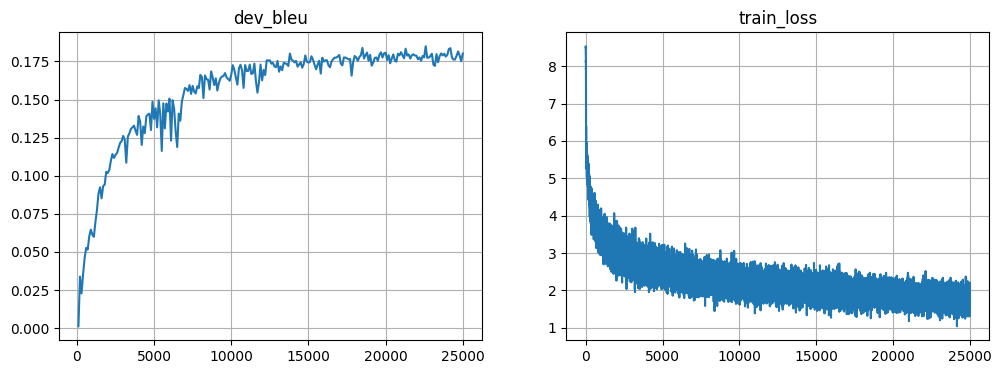

Mean loss=1.861


100%|██████████| 25000/25000 [19:28<00:00, 21.40it/s]


In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    loss_t = compute_loss(model, batch_inp, batch_out)
    opt.zero_grad()
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [ ]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

0.17911344913589308

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen with a shared lounge and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers free parking and free parking .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
k@@ ře@@ he@@ vsk airport is 30 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in the centre of mor@@ a beach , this air - conditioned villa features a terrace and a restaurant with a terrace and a restaurant . it features a swimming pool and a terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
the cathedral of saint nic@@ os is located in the centre of barcelona , 200 metres from the apartment .

в вашем распоряжении собственная ванная комната с душем и полотенца

# bpe with attention

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        super().__init__()
        self.name = name
        self.enc_size = enc_size
        self.dec_size = dec_size
        self.hid_size = hid_size
        self.activ = activ

        self.enc_linear = nn.Linear(enc_size, hid_size, bias=False)
        self.dec_linear = nn.Linear(dec_size, hid_size, bias=False)
        self.out_linear = nn.Linear(hid_size, 1, bias=False)


    def forward(self, enc, dec, inp_mask):

        enc_transformed = self.enc_linear(enc)
        dec_transformed = self.dec_linear(dec).unsqueeze(1)
        logits = self.out_linear(self.activ(enc_transformed + dec_transformed)).squeeze(2)

        replacing = (torch.ones(inp_mask.shape)*(-1e9)).to(device)
        a_t = torch.where((inp_mask==0).to(device), replacing, logits)

        probs = F.softmax(a_t, dim=-1)

        attn = torch.bmm(probs.unsqueeze(1), enc).squeeze(1)
        return attn, probs

In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        nn.Module.__init__(self)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        # <YOUR CODE: initialize layers>
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.attn = AttentionLayer(name, enc_size=hid_size, dec_size=hid_size, hid_size=attn_size)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def encode(self, inp, **flags):

        emb_inp = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(emb_inp)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)

        inp_mask = self.inp_voc.compute_mask(inp).to(device)

        attn, first_attn_probas = self.attn(enc_seq, dec_start, inp_mask)
        first_state = [dec_start, enc_seq, inp_mask, attn, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):

        dec_start = prev_state[0]
        enc_seq = prev_state[1]
        inp_mask = prev_state[2]
        attn = prev_state[3]


        prev_tokens_embs = self.emb_out(prev_tokens)


        dec_start_added_attn = dec_start + attn

        new_gru_activations = self.dec0(prev_tokens_embs, dec_start_added_attn)
        attn, first_attn_probas = self.attn(enc_seq, new_gru_activations, inp_mask)

        output_logits = self.logits(new_gru_activations)

        new_dec_state = [new_gru_activations, enc_seq, inp_mask, attn, first_attn_probas]
        return [new_dec_state, output_logits]

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

attn_model = AttentiveModel('attn', inp_voc, out_voc).to(device)
opt = torch.optim.Adam(attn_model.parameters(), lr=1e-3)
batch_size = 32

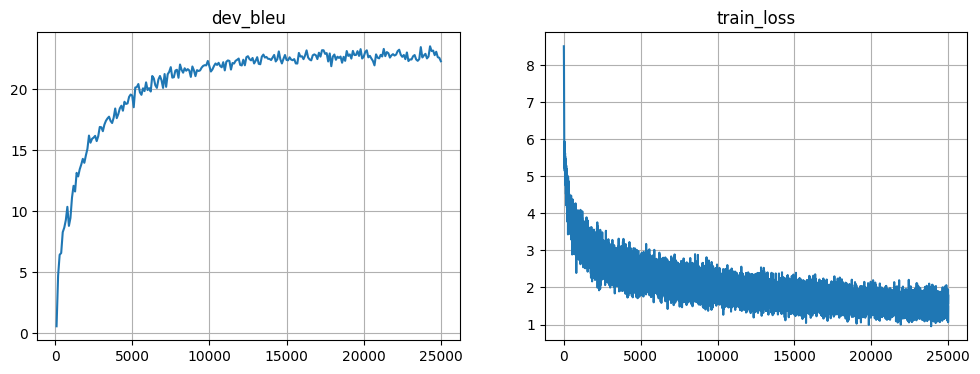

Mean loss=1.541


100%|██████████| 25000/25000 [42:08<00:00,  9.89it/s]


In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    loss_t = compute_loss(attn_model, batch_inp, batch_out)
    opt.zero_grad()
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(attn_model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [ ]:
np.mean(metrics['dev_bleu'][-10:], axis=0)[1]

22.81542280716281

# pretrained model

In [ ]:
with open('train_en.txt', 'w') as f_src,  open('train_ru.txt', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(src_line + '\n')
        f_dst.write(dst_line + '\n')

h

In [ ]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_metric
from tqdm import tqdm

model_name = 'utrobinmv/t5_translate_en_ru_zh_base_200'
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

bleu_metric = load_metric("bleu")

with open("train_en.txt", "r", encoding="utf-8") as f:
    src_texts = f.readlines()
with open("train_ru.txt", "r", encoding="utf-8") as f:
    tgt_texts = f.readlines()

assert len(src_texts) == len(tgt_texts)

batch_size = 16

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from tqdm import tqdm, trange
for i in trange(0, len(src_texts), 16, desc="Translating", unit="batch"):
    batch_src_texts = src_texts[i:i+batch_size]
    batch_tgt_texts = tgt_texts[i:i+batch_size]

    input_ids = tokenizer([f"translate to ru: {text.strip()}" for text in batch_src_texts], return_tensors="pt", padding=True, truncation=True, max_length=512).input_ids
    input_ids = input_ids.to(device)

    with torch.no_grad():
        generated_tokens = model.generate(input_ids, max_length=512)

    translations = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

    for ref, translation in zip(batch_tgt_texts, translations):
        ref_list = [ref.strip().split()]
        pred_list = translation.split()
        bleu_metric.add(prediction=pred_list, reference=ref_list)

final_bleu_result = bleu_metric.compute()


In [ ]:
print(f"Mean BLEU Score: {final_bleu_result['bleu']}")

Mean BLEU Score: 0.18514352802346976


# fine-tuned model

In [ ]:
import pandas as pd
from tqdm.auto import tqdm

data_path = 'data.txt'

dataset = pd.read_csv(
        data_path,
        sep='\t',
        header=None,
        names=['english', 'russian'],
        engine='python',
        quoting=3,
        on_bad_lines='skip'
    )

print(dataset.head())



                                             english  \
0  Cordelia Hotel is situated in Tbilisi, a 3-min...   
1  At Tupirmarka Lodge you will find a 24-hour fr...   
2  Featuring free WiFi in all areas, Naigao Xiaow...   
3  Each has a TV and a private bathroom with shower.   
4  Your room comes with air conditioning and sate...   

                                             russian  
0  Отель Cordelia расположен в Тбилиси, в 3 минут...  
1  В числе удобств лоджа Tupirmarka круглосуточна...  
2  Апартаменты Naigao Xiaowo расположены в городе...  
3  В вашем распоряжении также телевизор и собстве...  
4  Номер оснащен кондиционером и спутниковым теле...  


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import load_dataset, load_metric, Dataset
import pandas as pd
from tqdm.auto import tqdm
import sentencepiece

model_name = "utrobinmv/t5_translate_en_ru_zh_base_200"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


train_dataset = dataset.sample(frac=0.8, random_state=200)
val_dataset = dataset.drop(train_dataset.index)
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)
def tokenize_function(examples):
    inputs = [f"translate ru: {text}" for text in examples['english']]
    targets = [text for text in examples['russian']]
    model_inputs = tokenizer(inputs, max_length=128, padding="max_length", truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    evaluation_strategy="steps",
    logging_dir='./logs',
    save_strategy="no"
)

bleu_metric = load_metric("bleu")


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer
)




tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/tmp/ipykernel_413/2580331749.py:42: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("bleu")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
trainer.train()

model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/spiece.model',
 './trained_model/added_tokens.json')

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_path = "./trained_model"  # Adjust this path if your model is saved in a different directory
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch

dataset = val_dataset

class TranslationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item = self.dataframe.iloc[idx]
        source_text = "translate to ru: " + item['english']
        target_text = item['russian']

        # Tokenize the source text
        source_encoded = self.tokenizer(
            source_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Tokenize the target text
        target_encoded = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": source_encoded.input_ids.squeeze(0),
            "attention_mask": source_encoded.attention_mask.squeeze(0),
            "labels": target_encoded.input_ids.squeeze(0)
        }

# Create dataset and DataLoader
translation_dataset = TranslationDataset(dataset, tokenizer)
eval_dataloader = DataLoader(translation_dataset, batch_size=16)


In [ ]:
from datasets import load_metric

bleu_metric = load_metric("bleu", trust_remote_code=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for batch in tqdm(eval_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        # Generate output sequences without providing decoder_input_ids
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)

    # Decode predictions
    decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(batch['labels'].to(device), skip_special_tokens=True)

    # Format data for BLEU score evaluation
    references = [[label.split()] for label in decoded_labels]
    predictions = [pred.split() for pred in decoded_preds]

    bleu_metric.add_batch(predictions=predictions, references=references)

bleu_score = bleu_metric.compute()
print(f"BLEU score: {bleu_score['bleu']}")


  0%|          | 0/625 [00:00<?, ?it/s]

BLEU score: 0.31091058332355676


basic conclusion:
without attention models are the fastest, but give the low-quality result, attention was the hardest to implement and fine-tuning was the most beautiful option to me
p.s. i was shocked from the default batch_size=256 :)